<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband/Aging_CRV127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and get a ticket

In [1]:
#Need to execute this cell and then restart the environment at the first use
#You can also ignore it if no need to pretty plots
!pip install -q hist
!pip install -q mplhep
import hist

import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import subprocess
import numpy as np
import matplotlib.dates as mdates

pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 100)

In [3]:
!apt-get -qq install krb5-user > /dev/null
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'
!kinit oksuzian@FNAL.GOV

--2022-07-08 00:03:50--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf.6’

krb5.conf.6         100%[===================>]  17.08K  --.-KB/s    in 0.03s   

2022-07-08 00:03:51 (536 KB/s) - ‘krb5.conf.6’ saved [17486/17486]

Password for oksuzian@FNAL.GOV: 


#Get tarballs with txt and pdf files

In [4]:
!scp  -r -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/pnfs/mu2e/tape/phy-etc/bck/mu2e/CRV_wideband_cosmics/crvaging-001 .
!cp crvaging-001/tgz/*/*/bck.mu2e.CRV_wideband_cosmics.crvaging-001.*.tgz .
!for f in bck.mu2e.CRV_wideband_cosmics.crvaging-001.*.tgz; do tar xf "$f"; done

#Make signal and calibration dataframes

In [5]:
import glob

df_data = pd.DataFrame([])
listing = glob.glob('*reco/*.txt')
for f in listing:
  fname = f.split("/")
  runnum = fname[1].split(".")[4].split("_")[0]
  subrun = fname[1].split(".")[4].split("_")[1]
  df_ = pd.read_csv(f, sep="\s+", skiprows=2, names=["feb", "chan", "PE", "PEcorr"])
  df_['run'] = runnum
  df_['subrun'] = subrun
  df_data = df_data.append(df_)

In [6]:
df_calib = pd.DataFrame([])
listing = glob.glob('*calib/*.txt')
for f in listing:
  if(os.path.getsize(f)==0):
    continue
  fname = f.split("/")
  runnum = fname[1].split(".")[4].split("_")[0]
  subrun = fname[1].split(".")[4].split("_")[1]
  df_ = pd.read_csv(f, sep="\s+", skiprows=2, names=["feb", "chan", "ped", "spe", "speT"])
  df_['run'] = runnum
  df_['subrun'] = subrun
  df_calib = df_calib.append(df_)

#Extract run-timestamps info from raw data 

In [7]:
cmd="ssh  -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov" # ssh to mu2e machine
cmd=cmd+" 'source /cvmfs/mu2e.opensciencegrid.org/setupmu2e-art.sh; setup mu2efiletools;" # setup mu2efiletools
cmd=cmd+"mu2eDatasetFileList raw.mu2e.CRV_wideband_cosmics.crvaging-001.dat | grep 000.dat | xargs head -1'" # get run and date info   
output = subprocess.check_output(cmd, shell=True, universal_newlines=True).split('\n')
output = list(filter(None, output))
output = [output[start::2] for start in range(2)] # split in  2 columns

In [8]:
import re
runlist = []
for x in output[0]:
     split_results = re.split('-|\.|_',x)
     runlist.append(split_results[11])

datelist = []
for x in output[1]:
     split_results = re.split('-|\.|_',x)
     datelist.append(split_results[4])

In [9]:
df_run_date = pd.DataFrame()
df_run_date['date']  = datelist
df_run_date['run']  = runlist

#Merge dataframes: run info with calib+signal 

In [10]:
df = pd.merge(df_data, df_calib,  how='left', on=['feb','chan', 'run', 'subrun'])
df = pd.merge(df_run_date, df, on="run")

#Convert columns to proper data types
df['date'] = pd.to_datetime(df['date']).dt.date
df['run'] = df['run'].astype(int)
df['subrun'] = df['subrun'].astype(int)

#Ramove bad runs
BAD_RUNS=[42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 67, 68, 69, 80, 83, 87, 88, 89, 91, 96, 101, 110, 115]
df = df[~df.run.isin(BAD_RUNS)]

df = df.query('PEcorr>0')
df['days']=df['date'].map(dt.datetime.toordinal)

pd.options.mode.chained_assignment = None
df['years']=(df['days']-df['days'].min())/365 #Convert to years

#Make plots

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<Figure size 800x600 with 0 Axes>

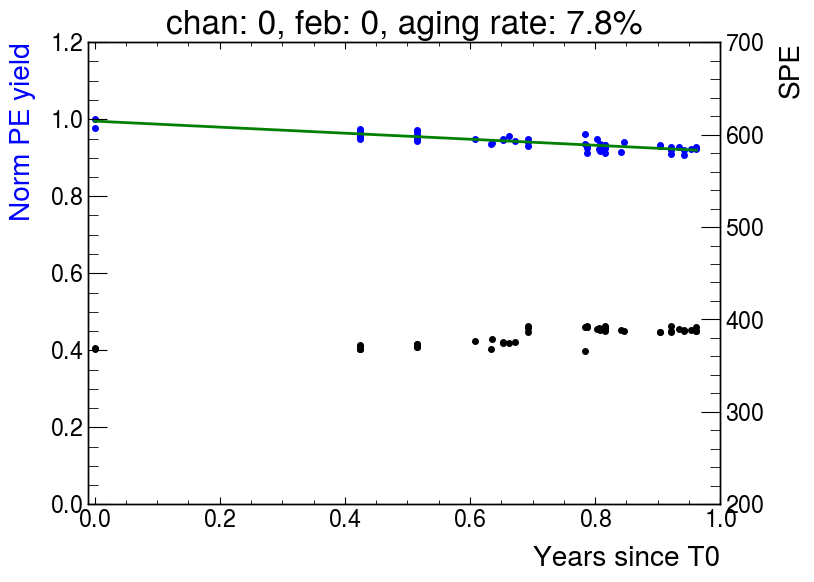

<Figure size 800x600 with 0 Axes>

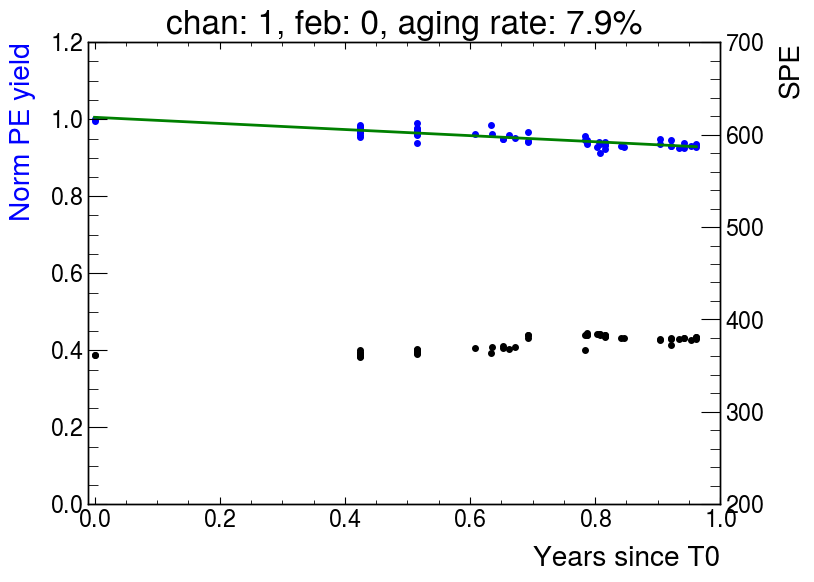

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

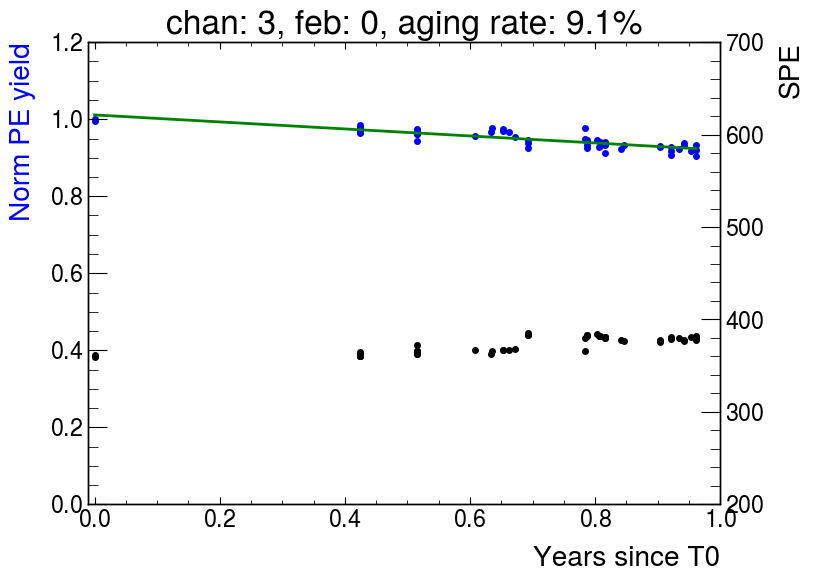

<Figure size 800x600 with 0 Axes>

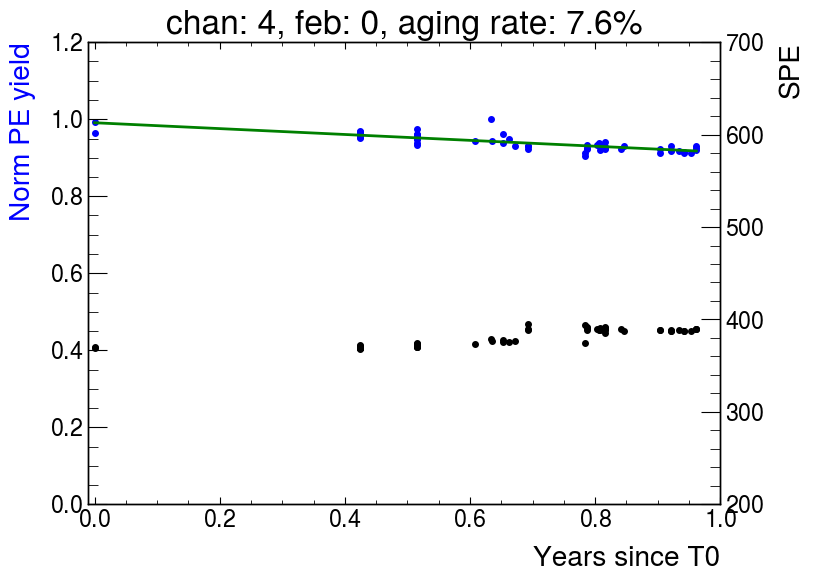

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

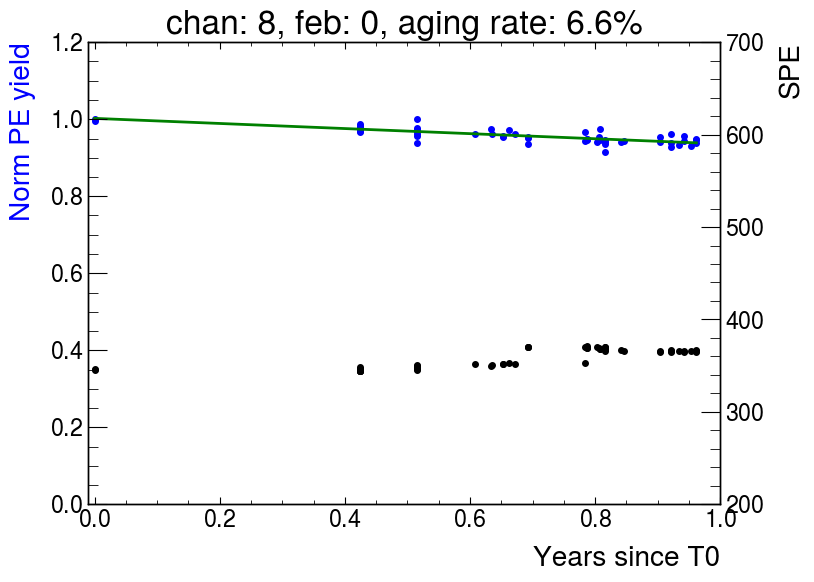

<Figure size 800x600 with 0 Axes>

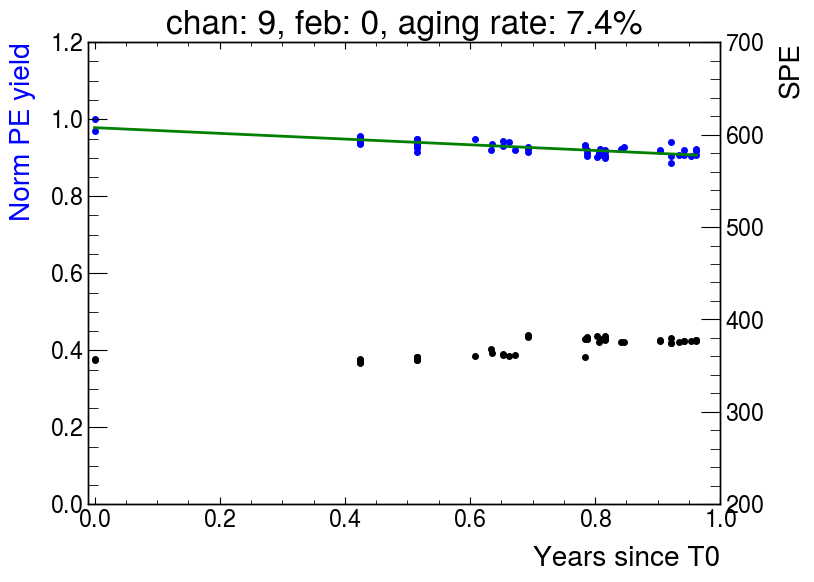

<Figure size 800x600 with 0 Axes>

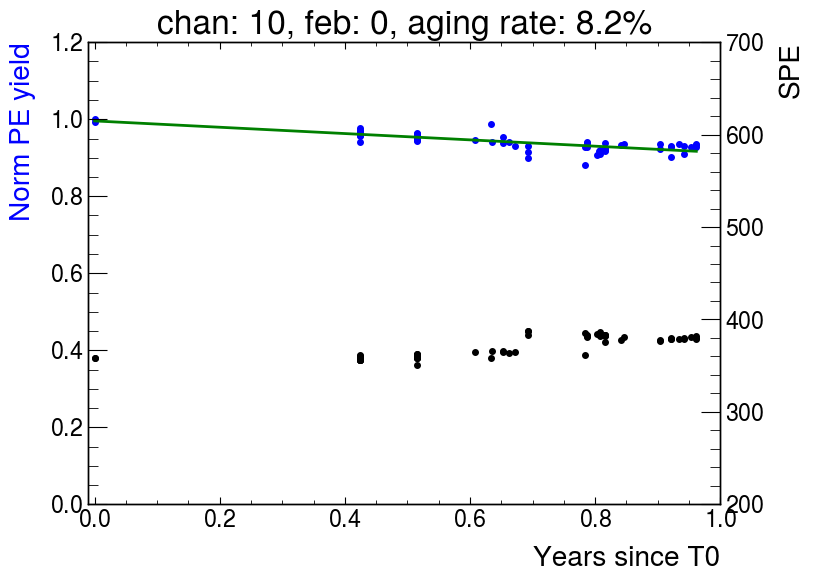

<Figure size 800x600 with 0 Axes>

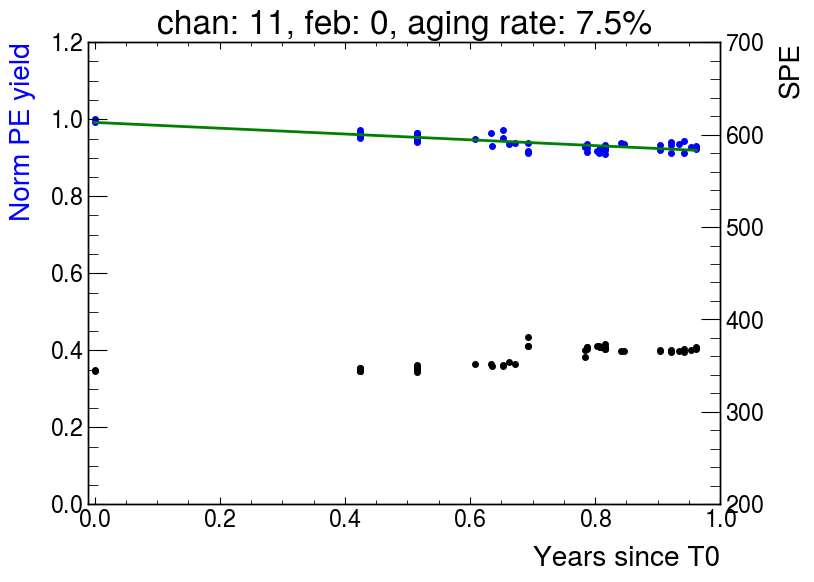

<Figure size 800x600 with 0 Axes>

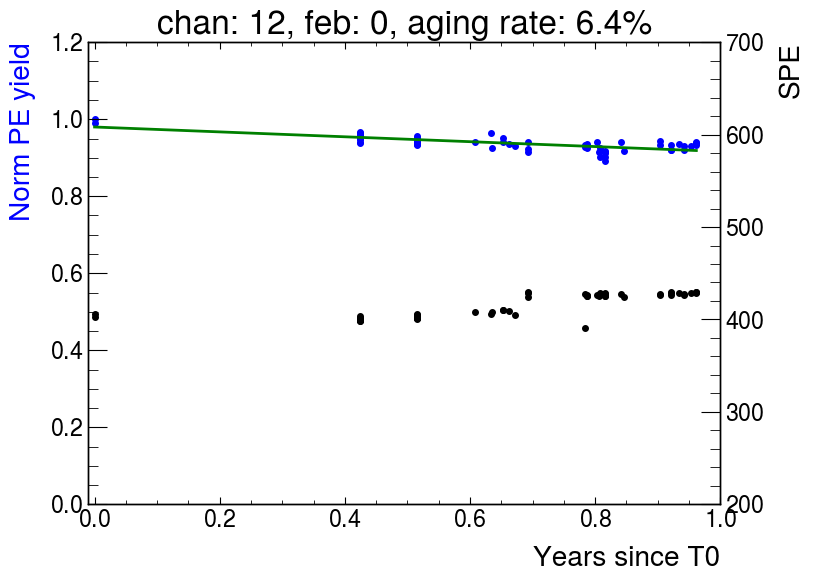

<Figure size 800x600 with 0 Axes>

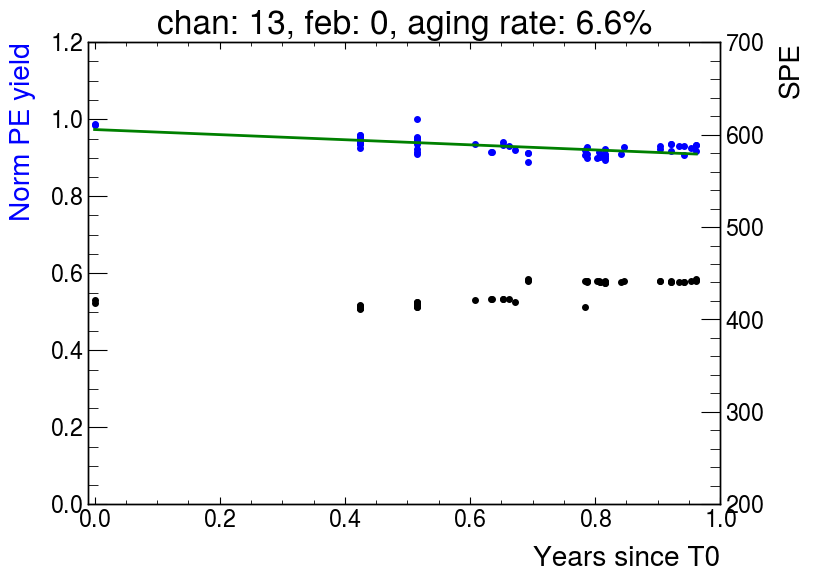

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

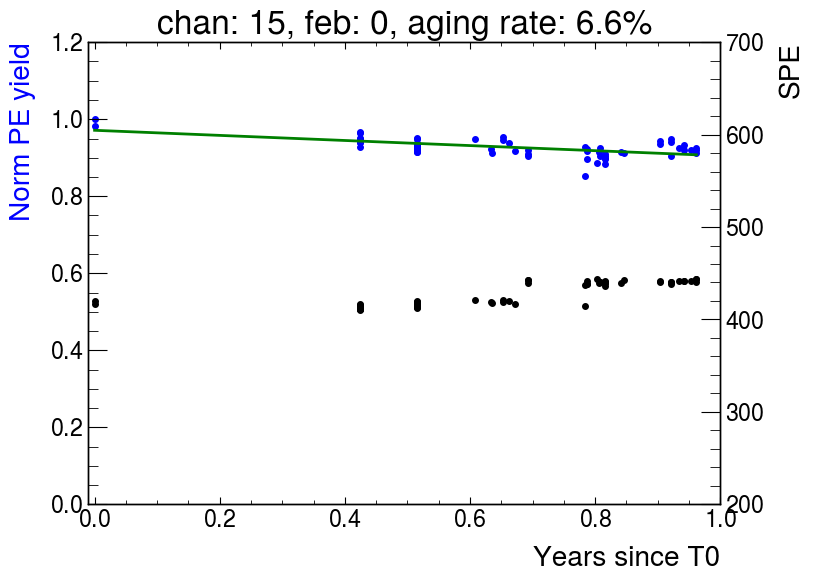

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

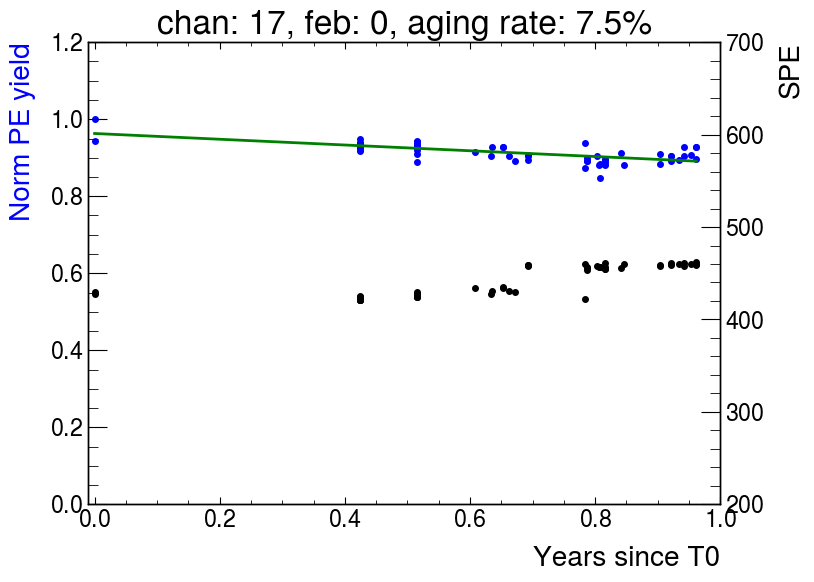

<Figure size 800x600 with 0 Axes>

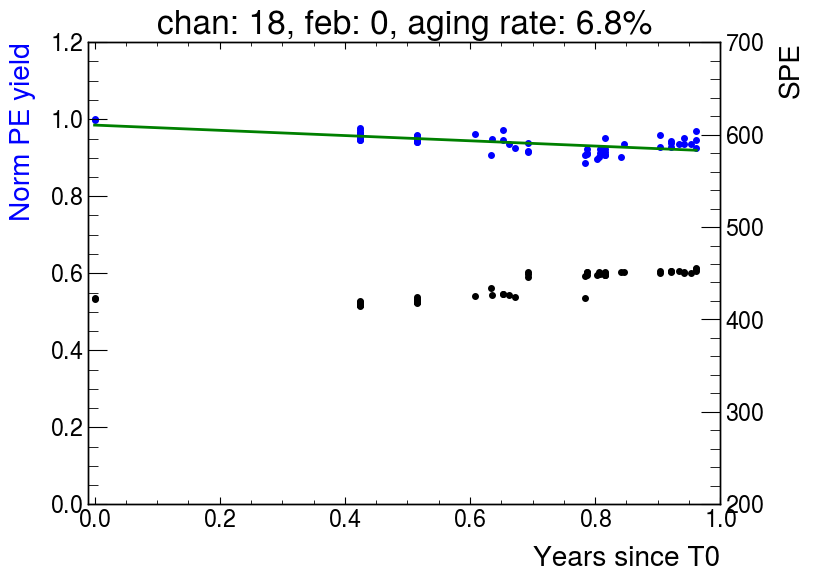

<Figure size 800x600 with 0 Axes>

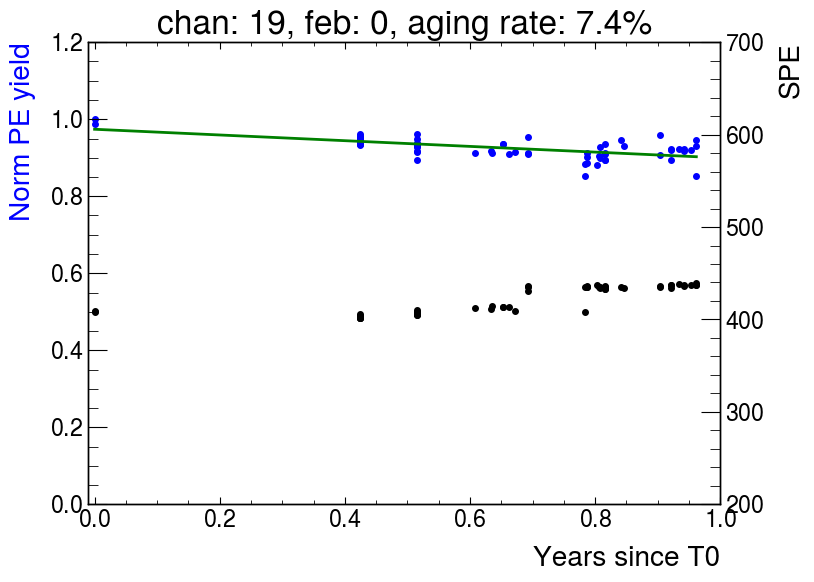

<Figure size 800x600 with 0 Axes>

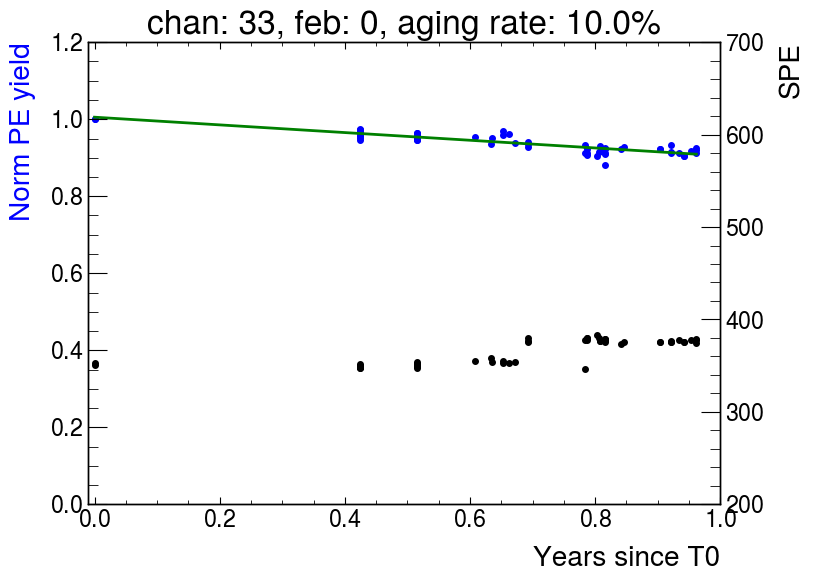

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

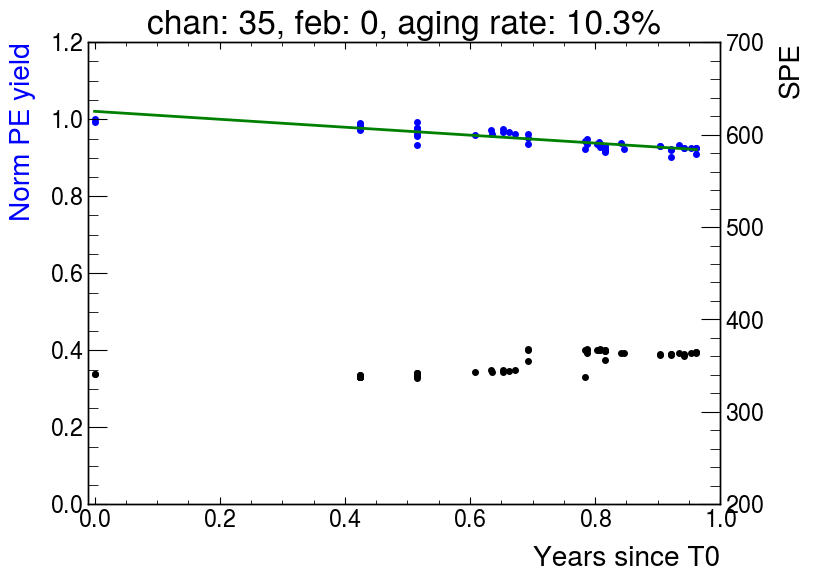

<Figure size 800x600 with 0 Axes>

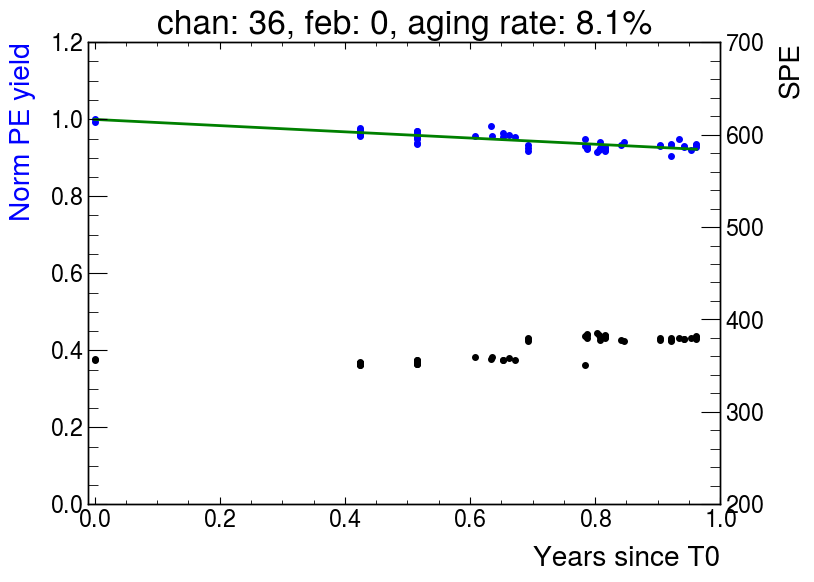

<Figure size 800x600 with 0 Axes>

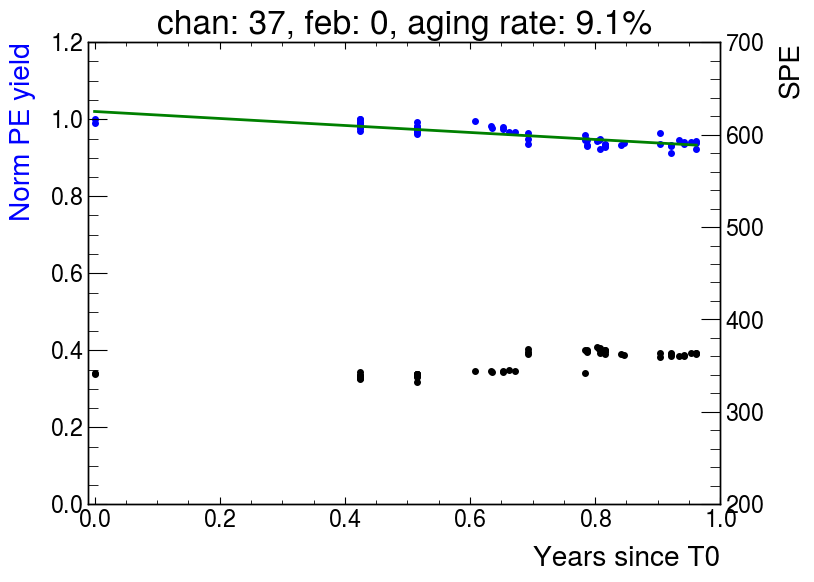

<Figure size 800x600 with 0 Axes>

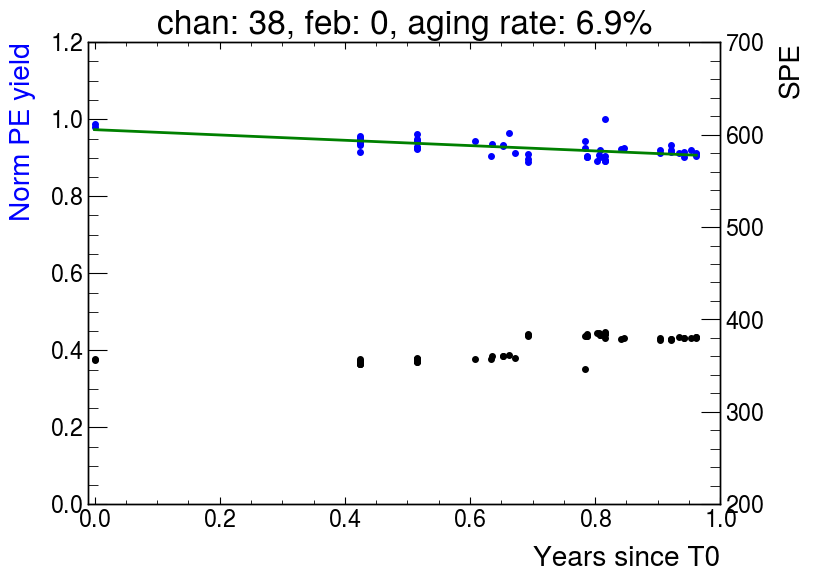

<Figure size 800x600 with 0 Axes>

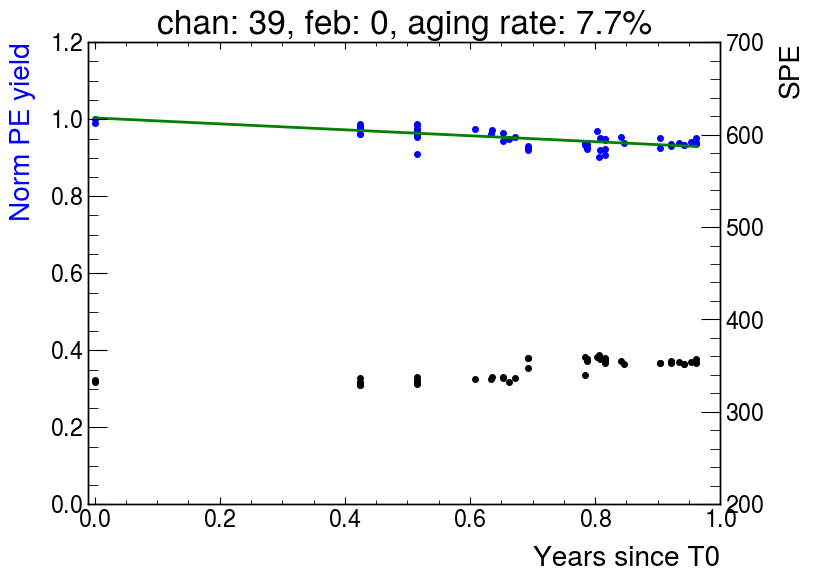

<Figure size 800x600 with 0 Axes>

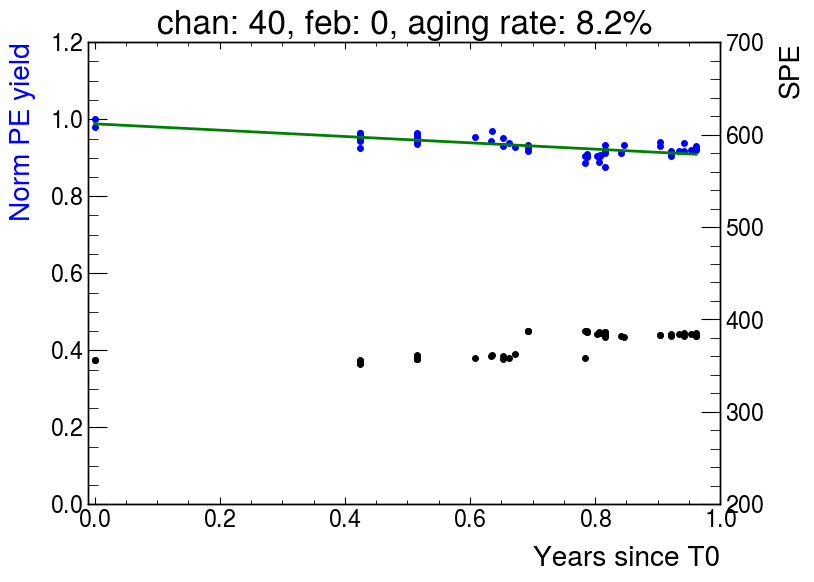

<Figure size 800x600 with 0 Axes>

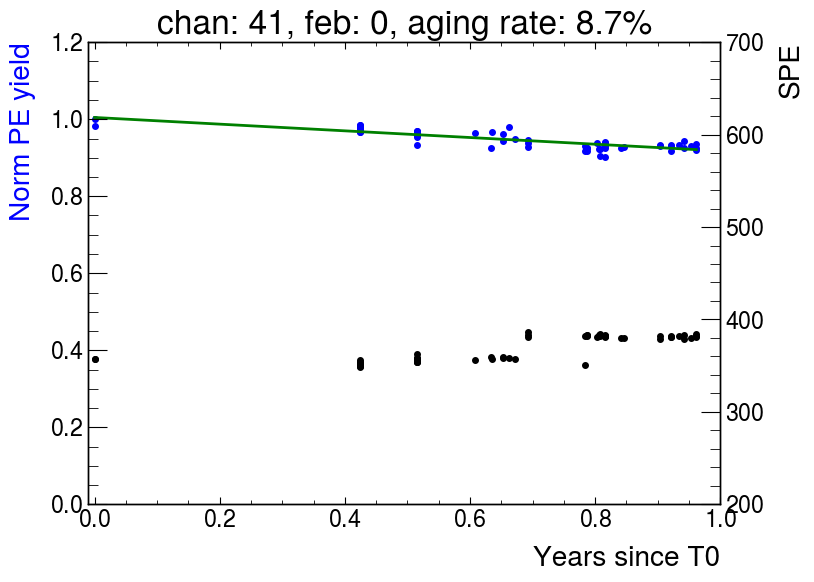

<Figure size 800x600 with 0 Axes>

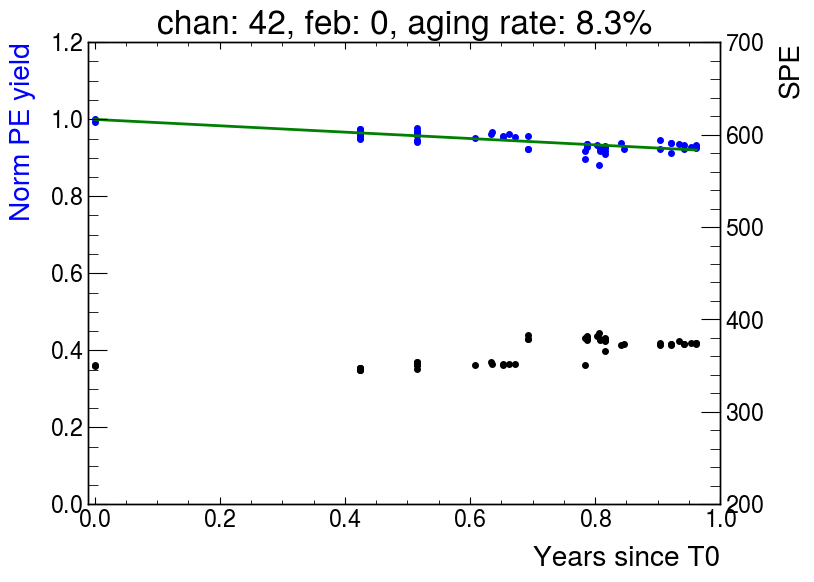

<Figure size 800x600 with 0 Axes>

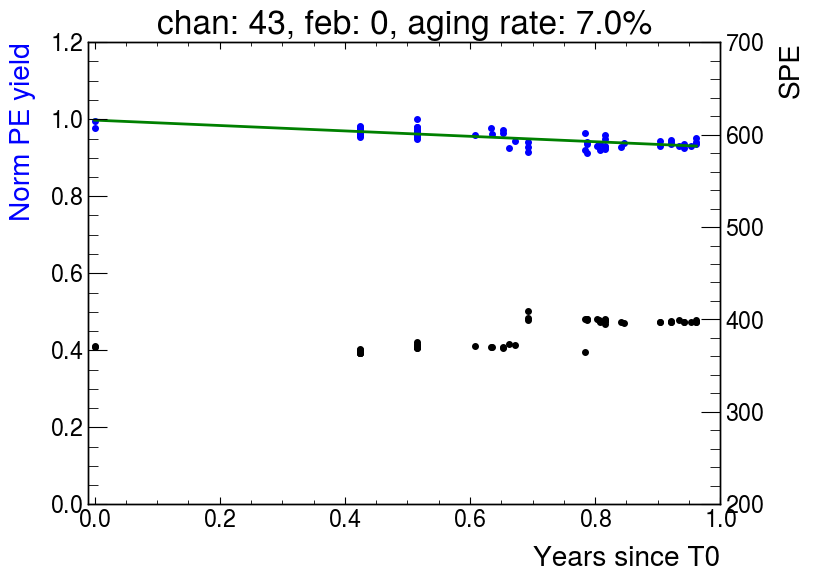

<Figure size 800x600 with 0 Axes>

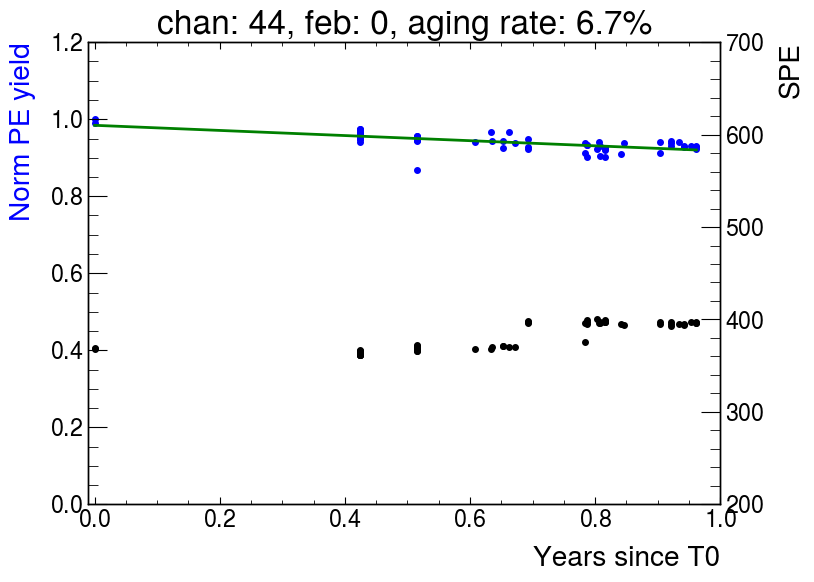

<Figure size 800x600 with 0 Axes>

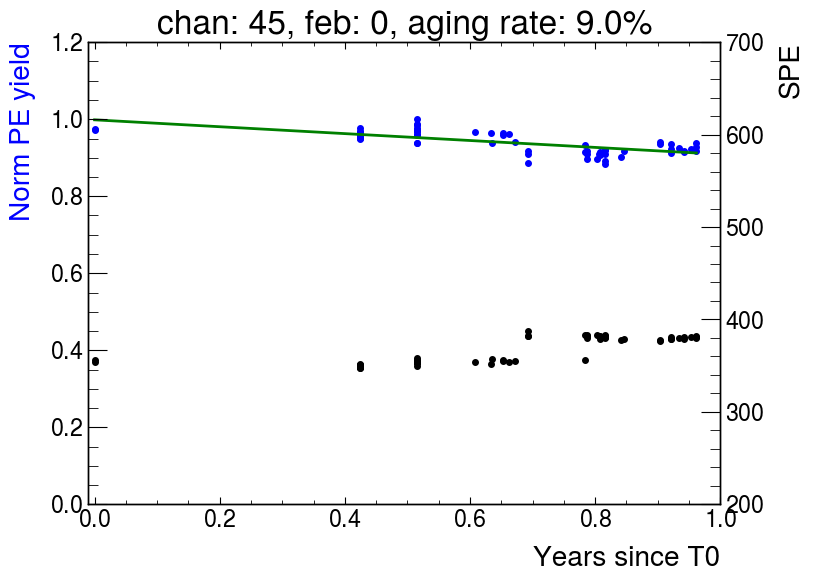

<Figure size 800x600 with 0 Axes>

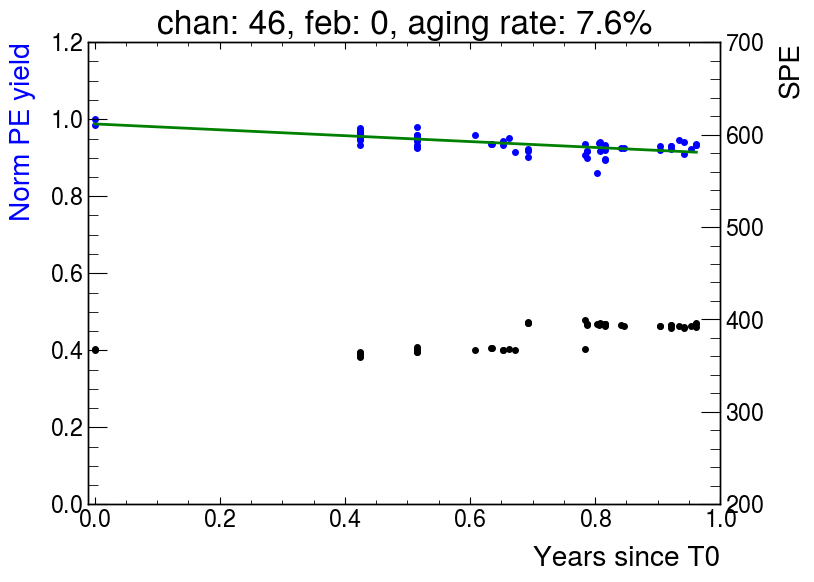

<Figure size 800x600 with 0 Axes>

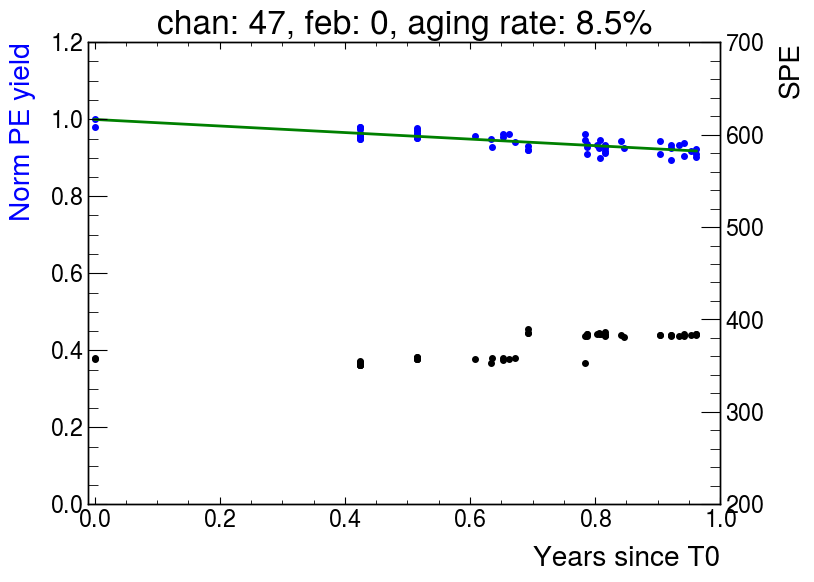

<Figure size 800x600 with 0 Axes>

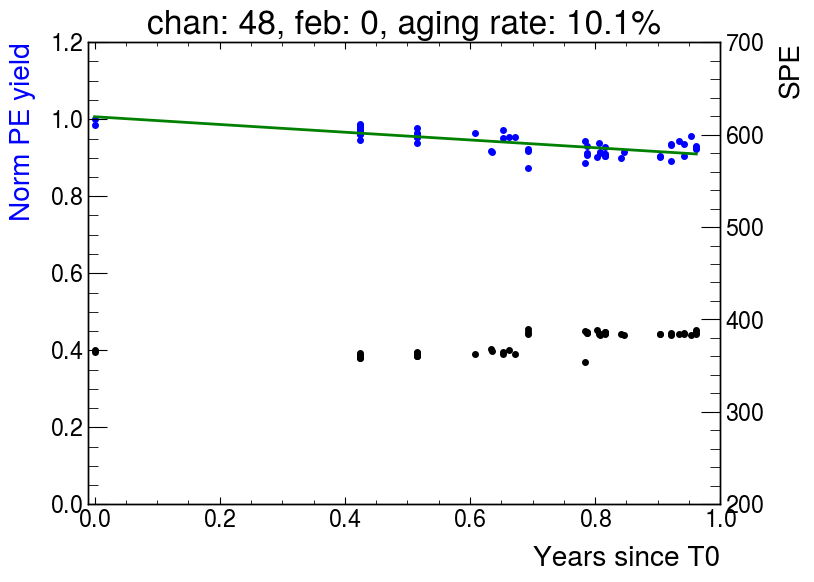

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

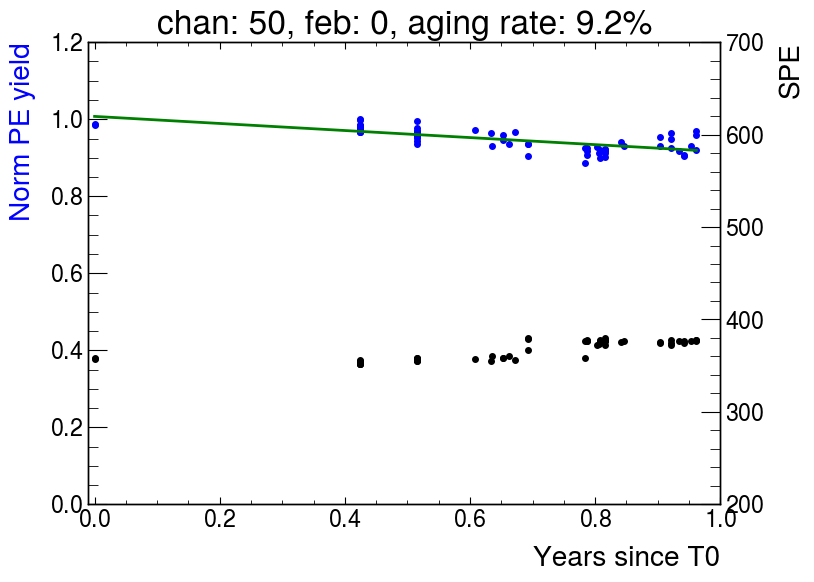

<Figure size 800x600 with 0 Axes>

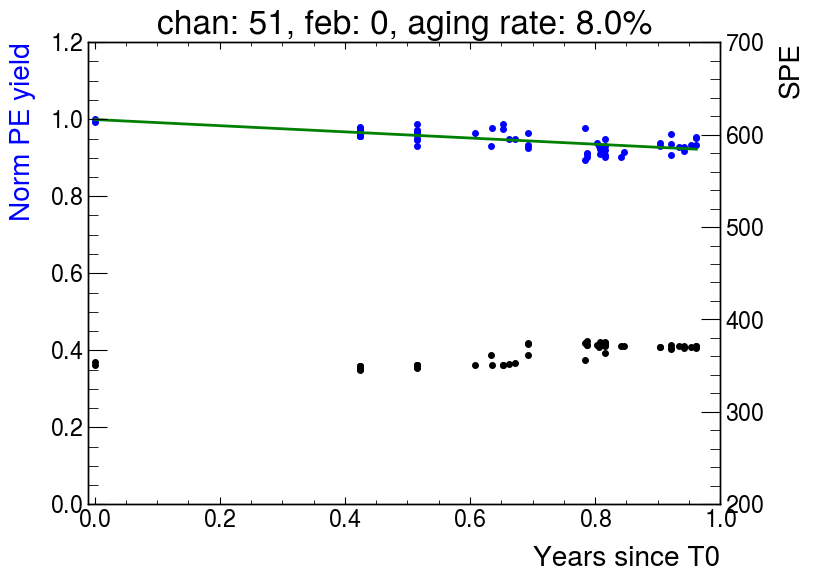

<Figure size 800x600 with 0 Axes>

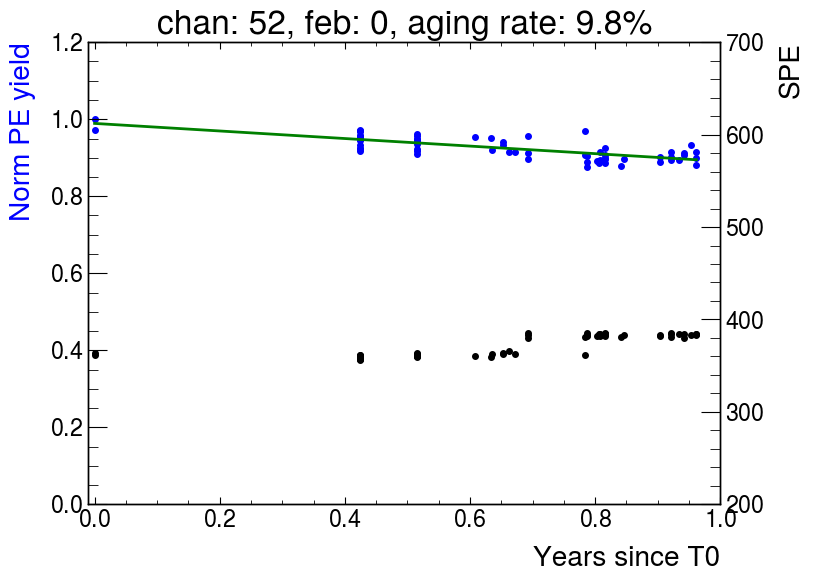

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

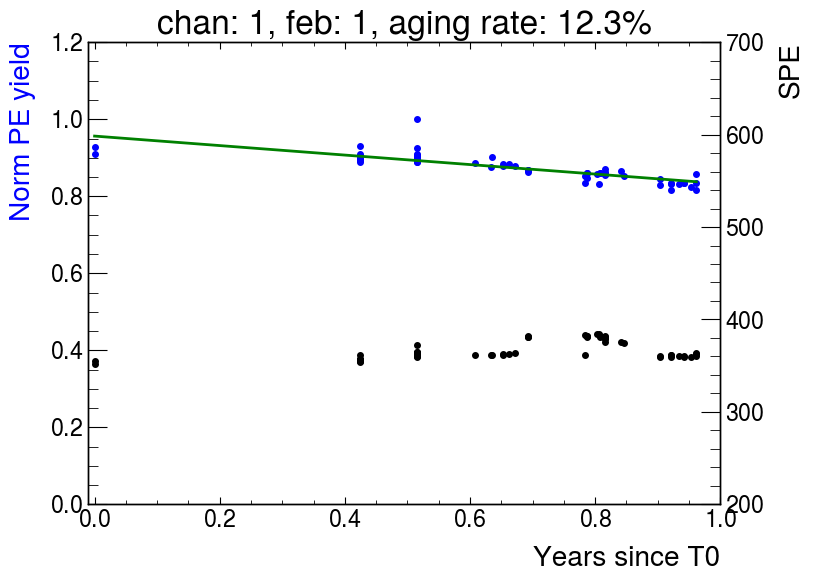

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

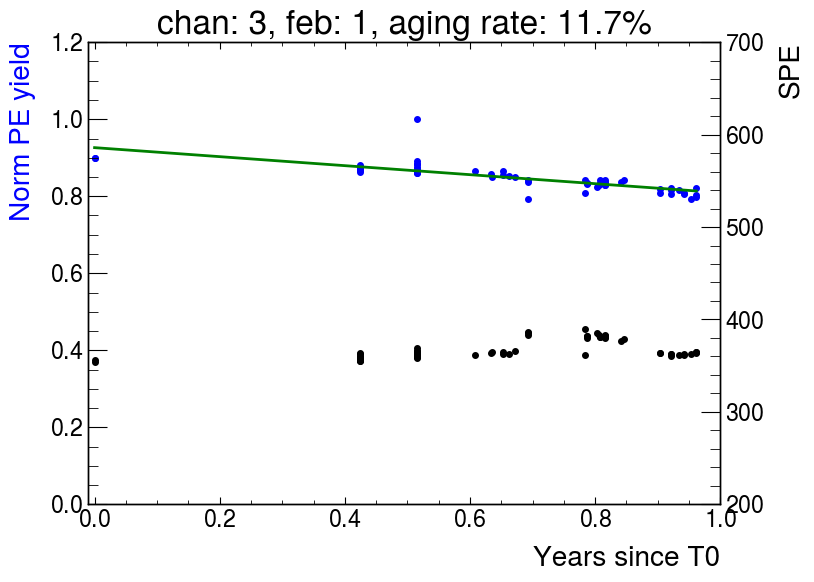

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

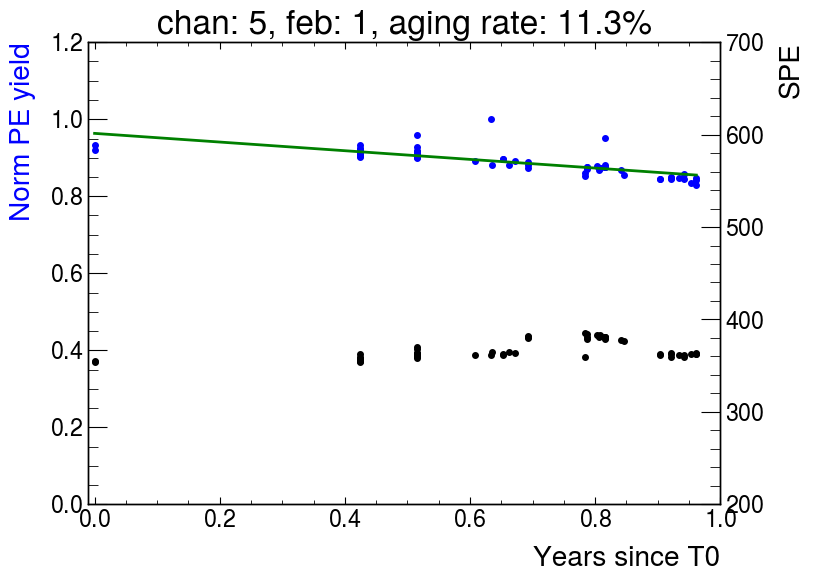

<Figure size 800x600 with 0 Axes>

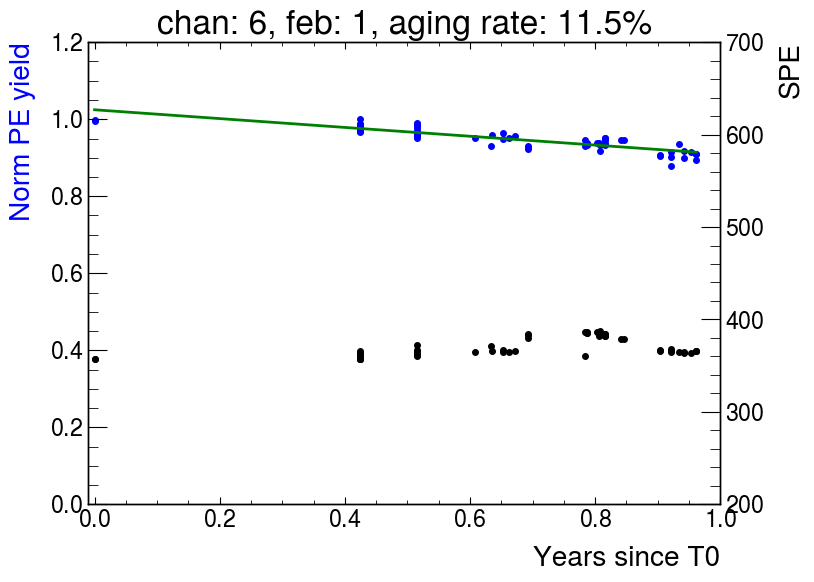

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

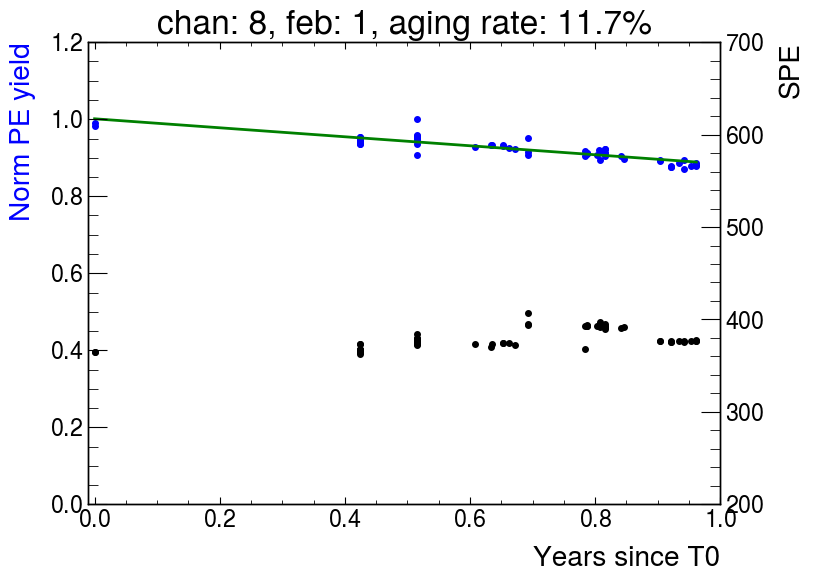

<Figure size 800x600 with 0 Axes>

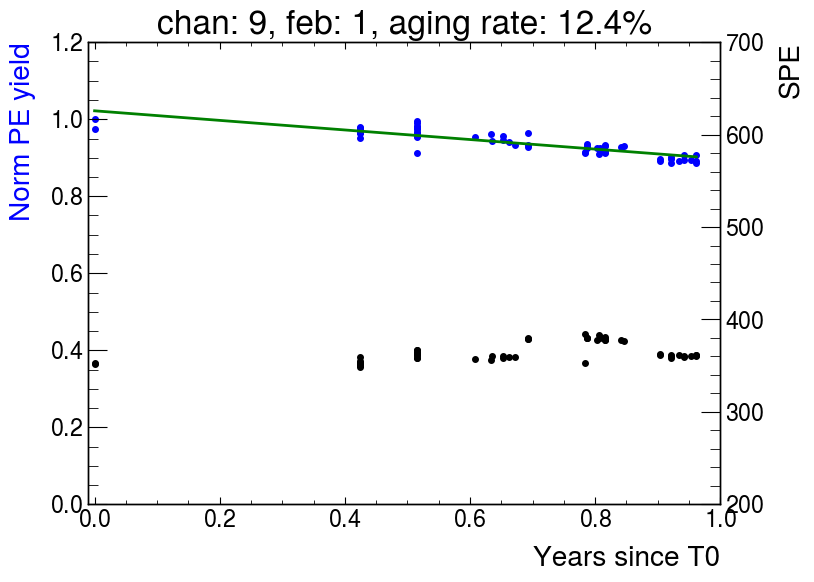

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

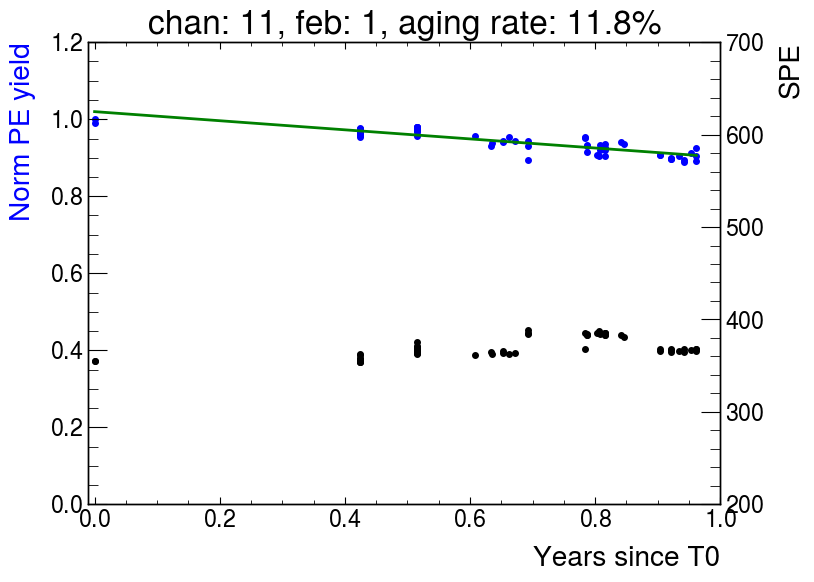

<Figure size 800x600 with 0 Axes>

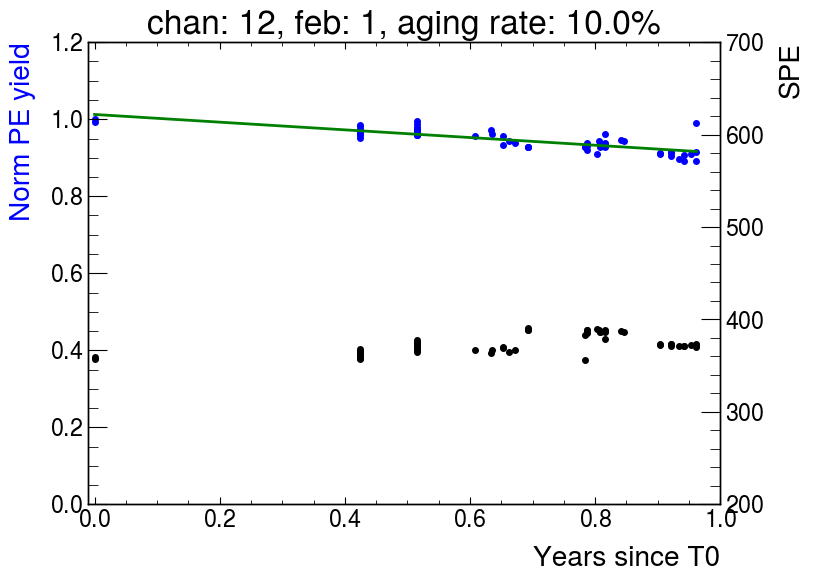

<Figure size 800x600 with 0 Axes>

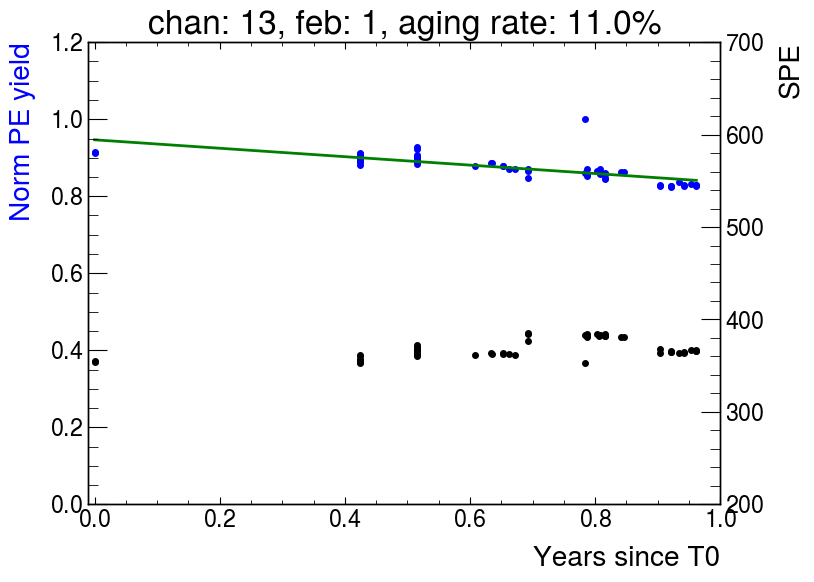

<Figure size 800x600 with 0 Axes>

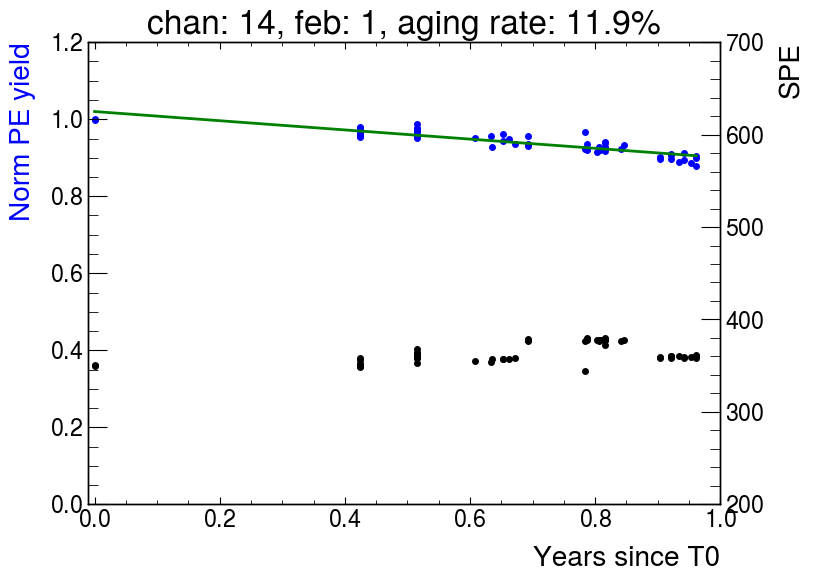

<Figure size 800x600 with 0 Axes>

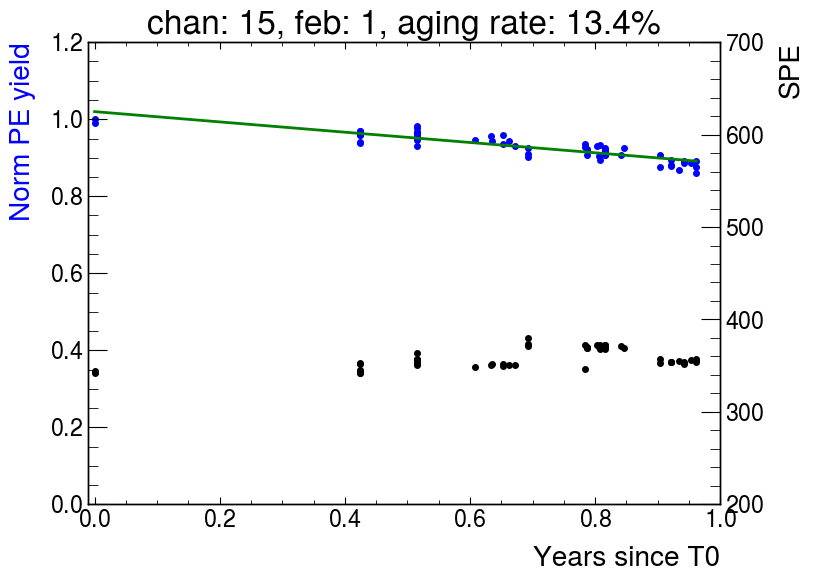

<Figure size 800x600 with 0 Axes>

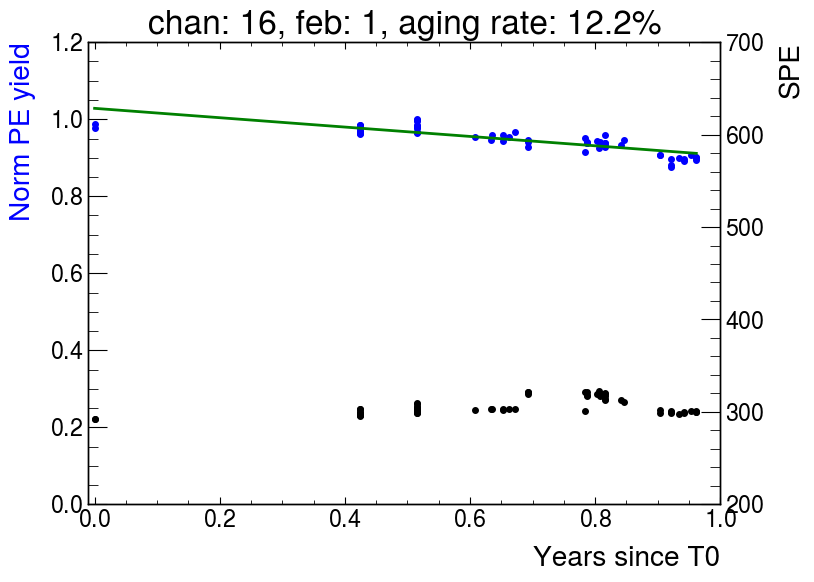

<Figure size 800x600 with 0 Axes>

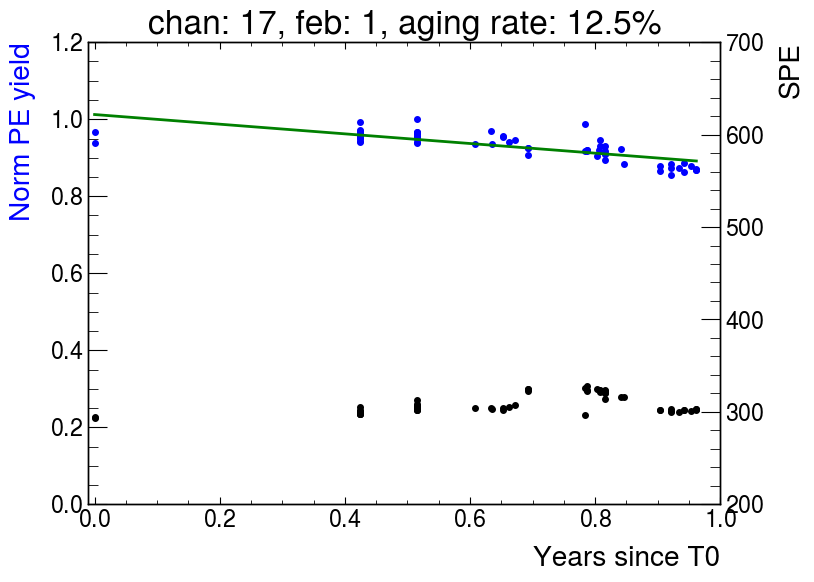

<Figure size 800x600 with 0 Axes>

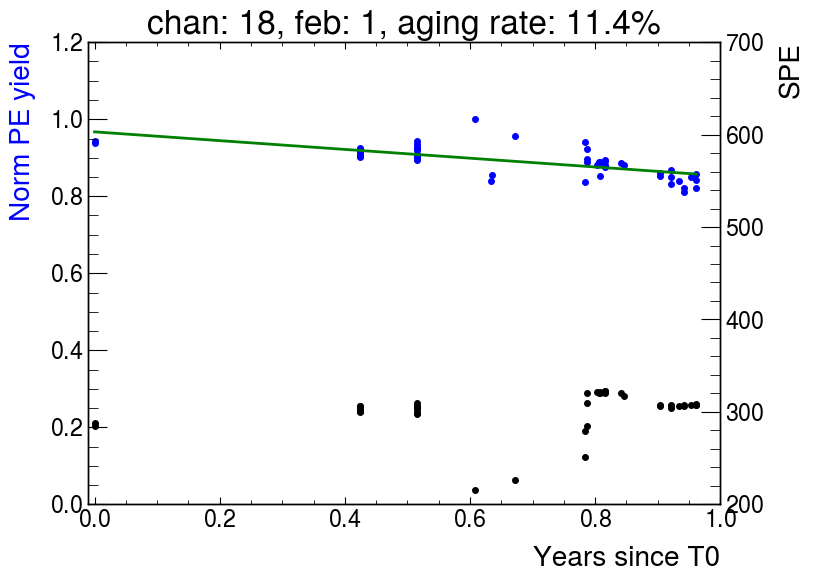

<Figure size 800x600 with 0 Axes>

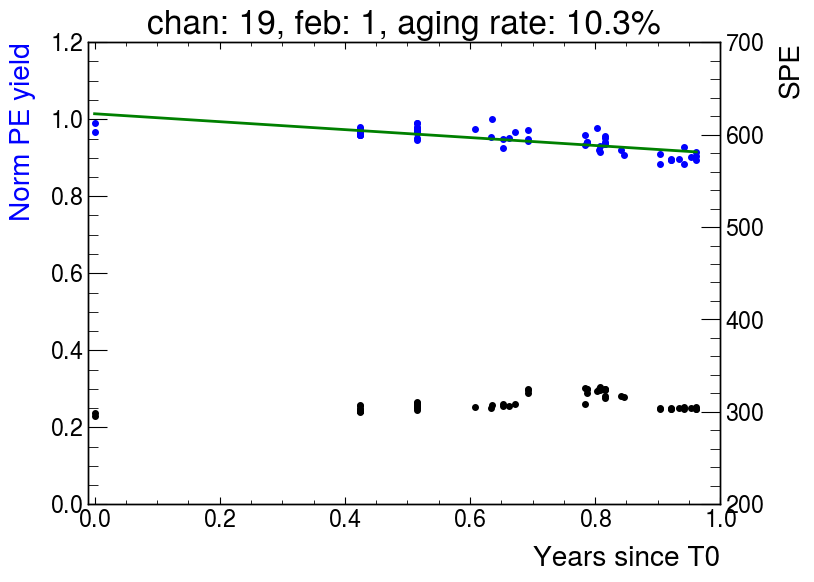

<Figure size 800x600 with 0 Axes>

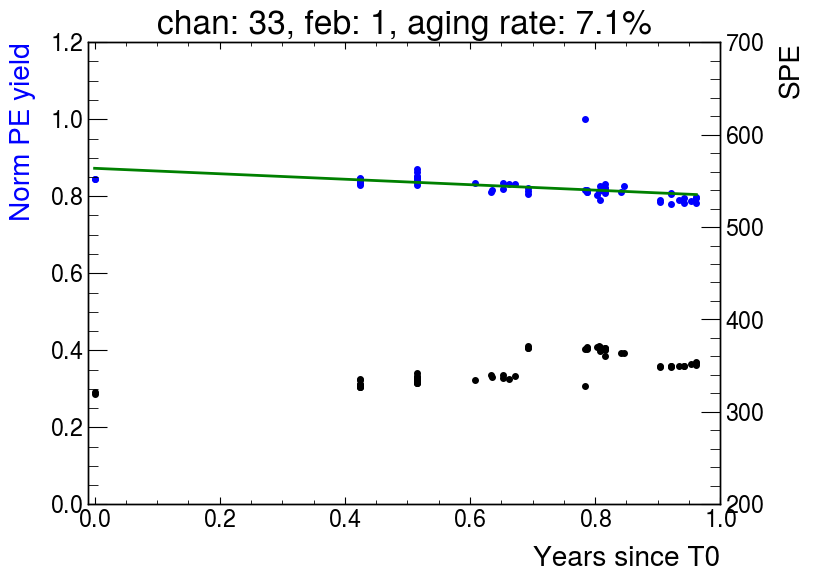

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

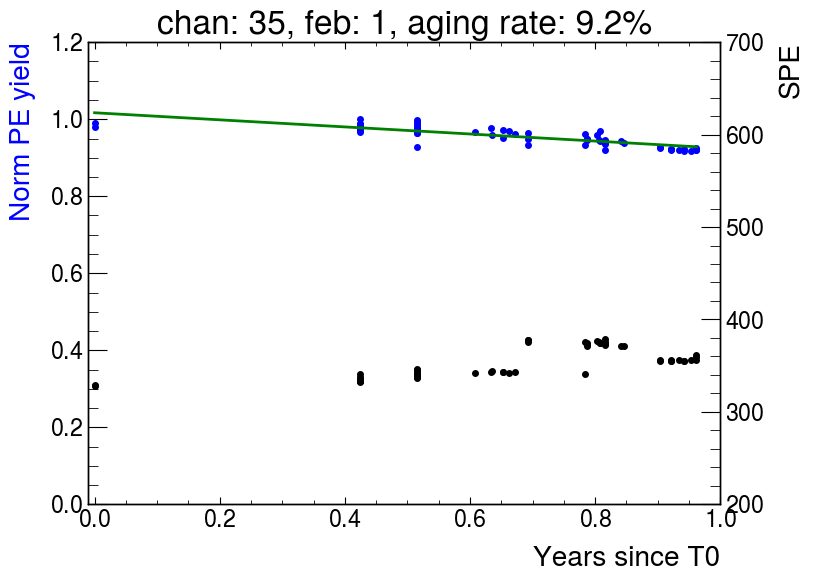

<Figure size 800x600 with 0 Axes>

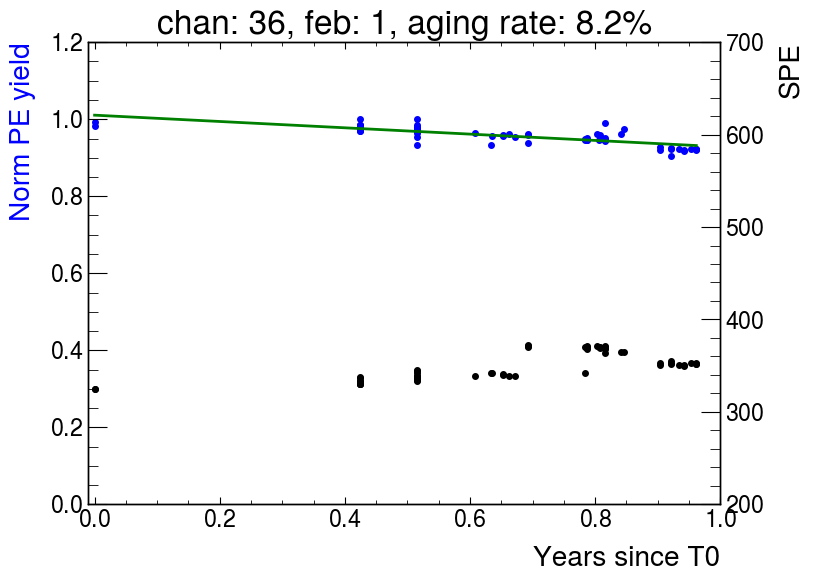

<Figure size 800x600 with 0 Axes>

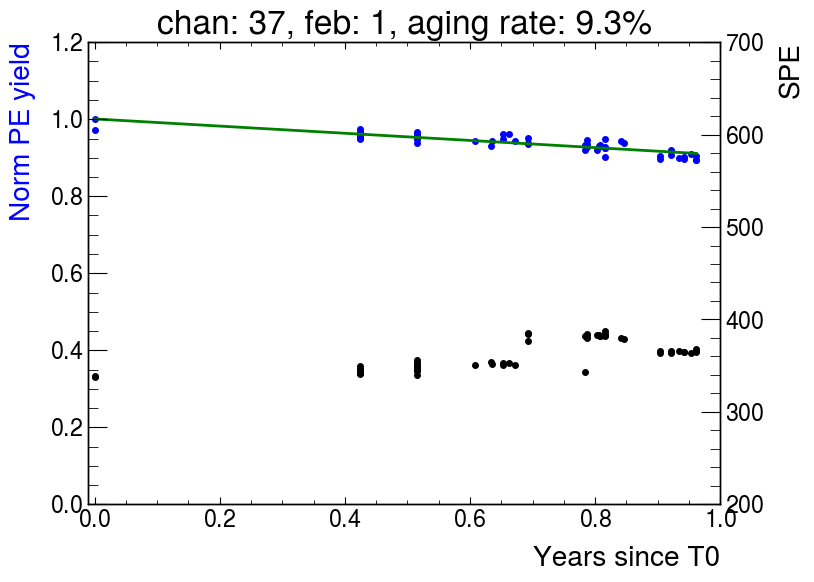

<Figure size 800x600 with 0 Axes>

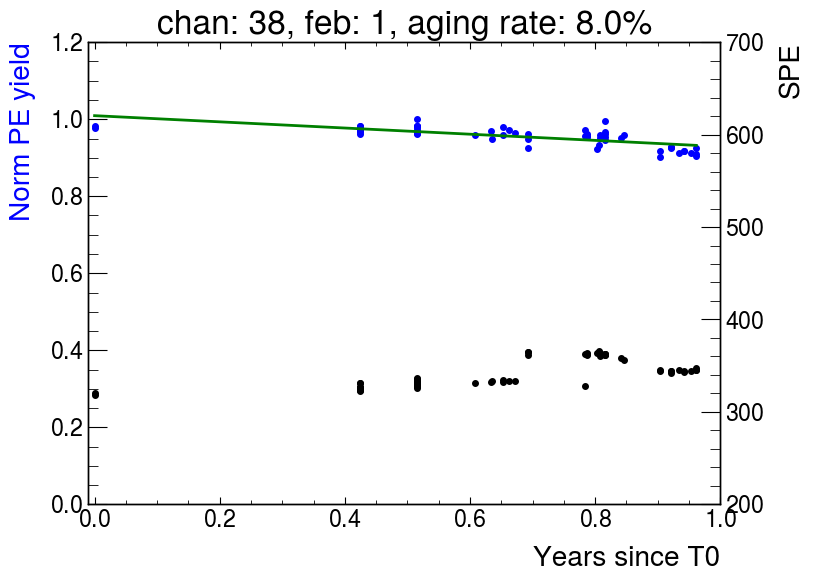

<Figure size 800x600 with 0 Axes>

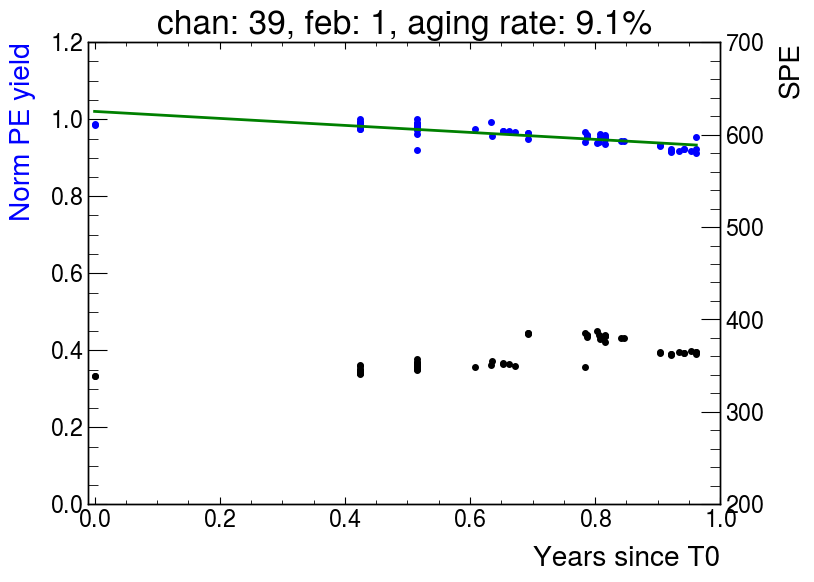

<Figure size 800x600 with 0 Axes>

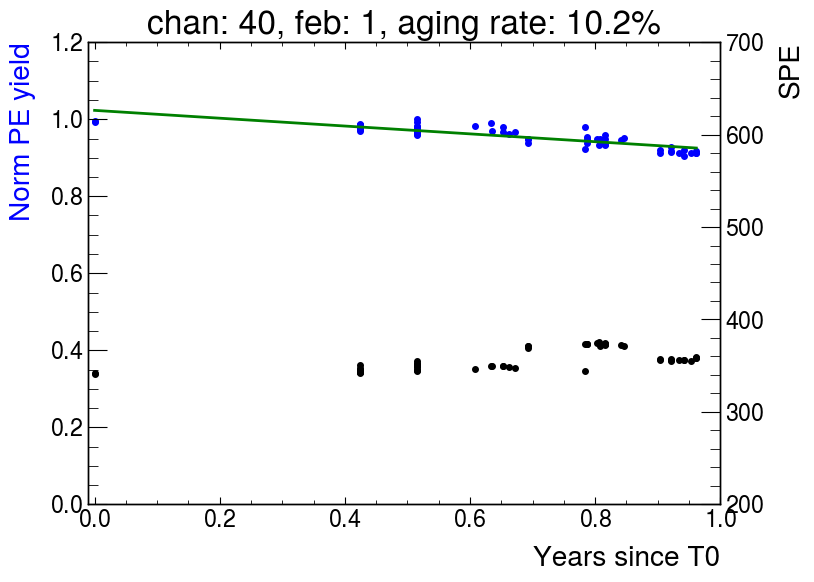

<Figure size 800x600 with 0 Axes>

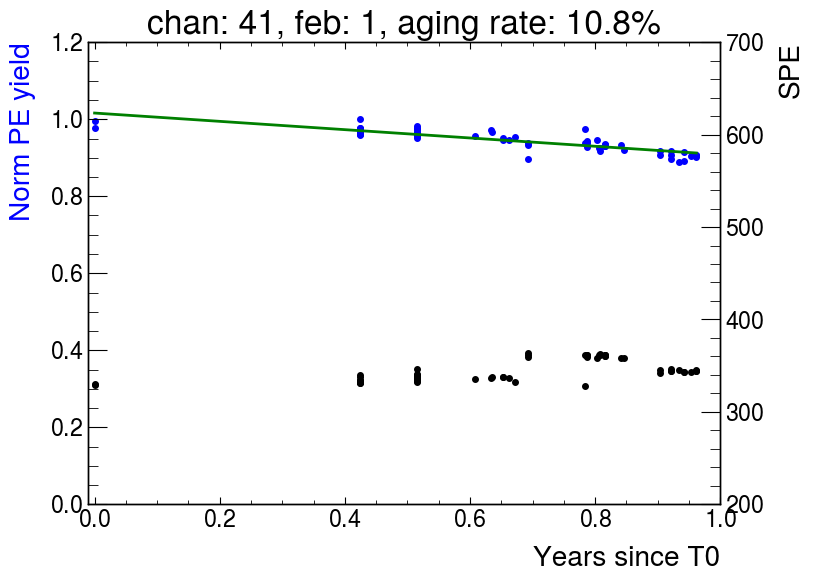

<Figure size 800x600 with 0 Axes>

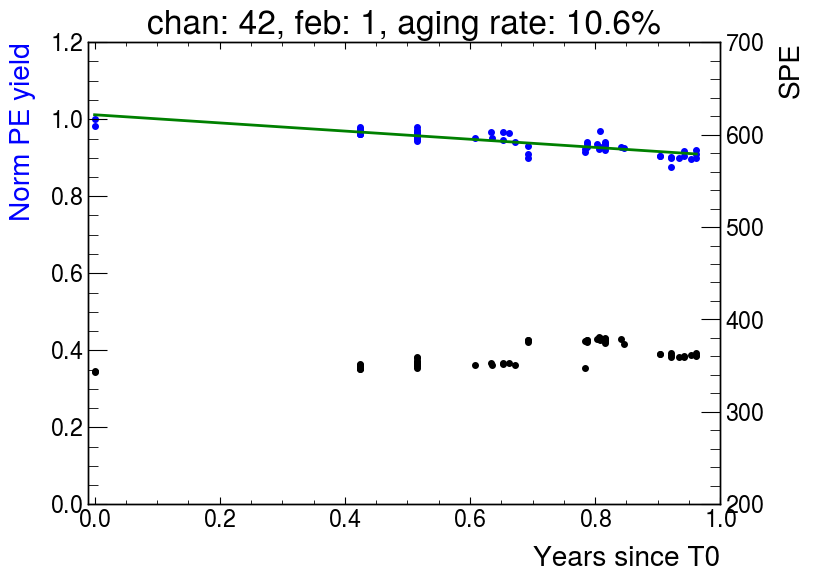

<Figure size 800x600 with 0 Axes>

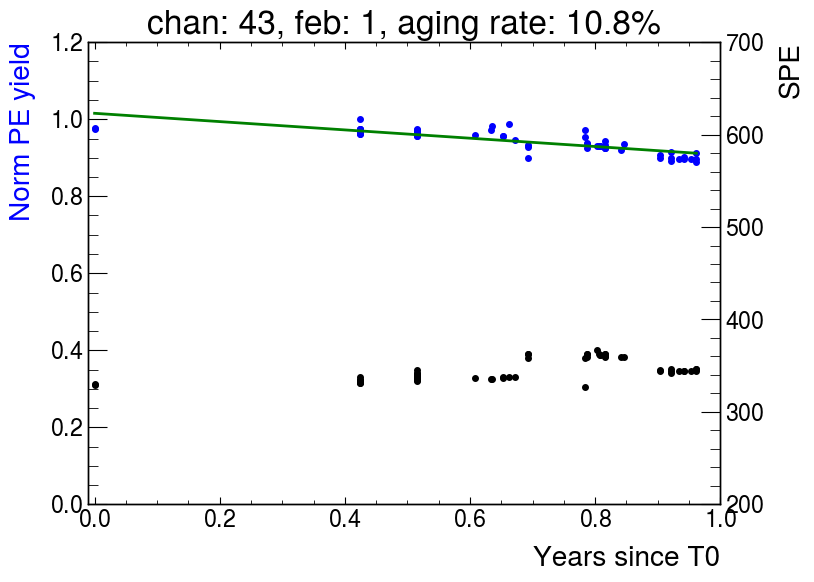

<Figure size 800x600 with 0 Axes>

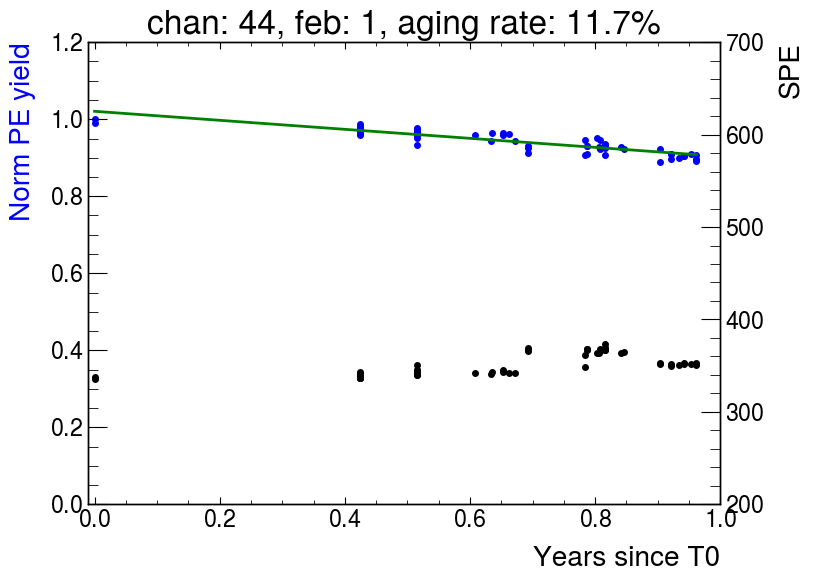

<Figure size 800x600 with 0 Axes>

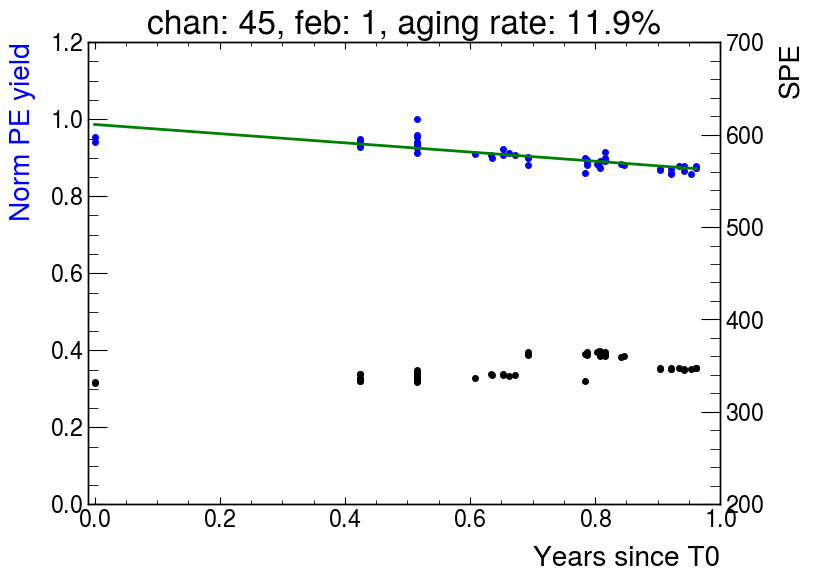

<Figure size 800x600 with 0 Axes>

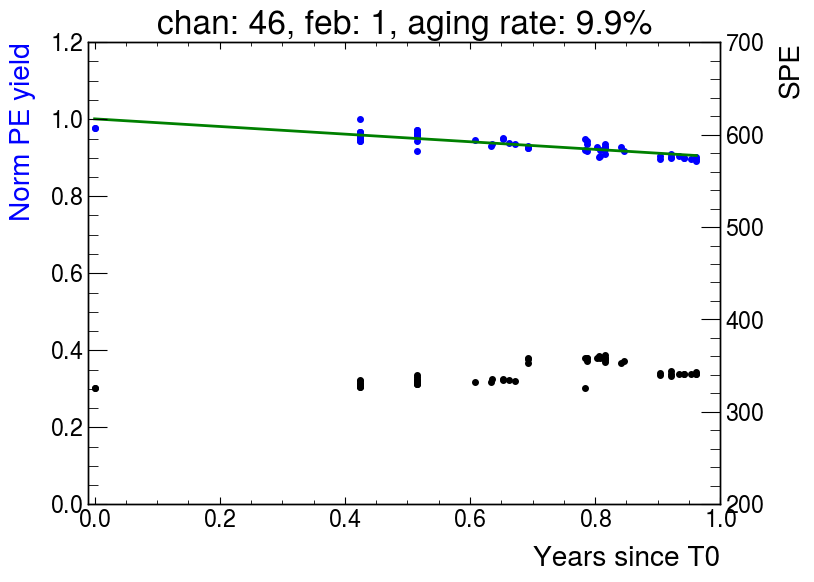

<Figure size 800x600 with 0 Axes>

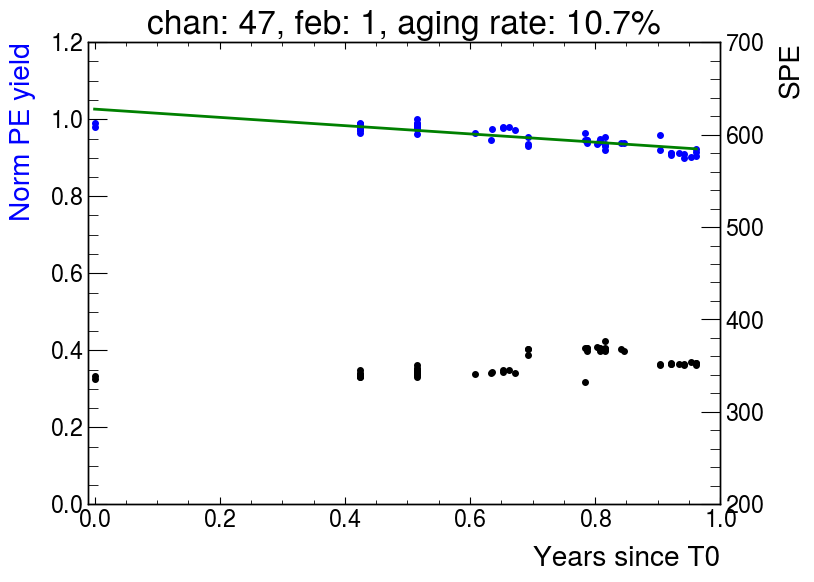

<Figure size 800x600 with 0 Axes>

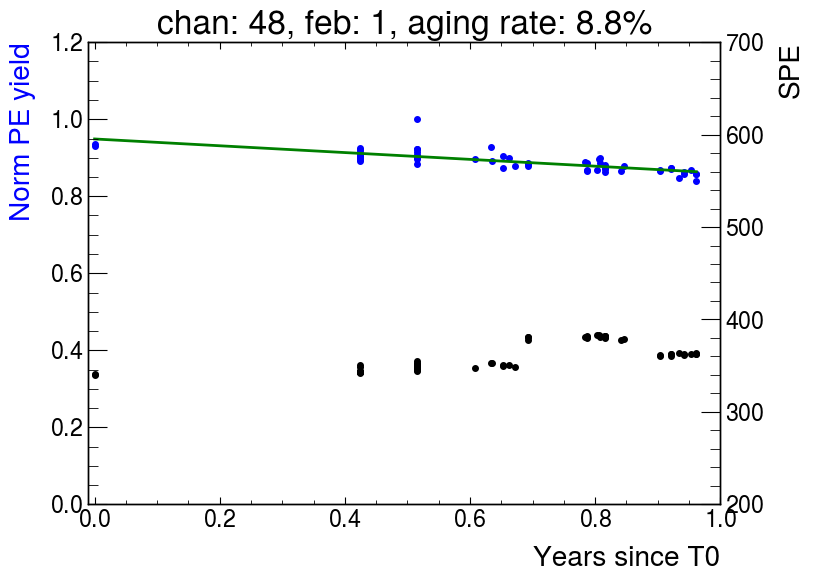

<Figure size 800x600 with 0 Axes>

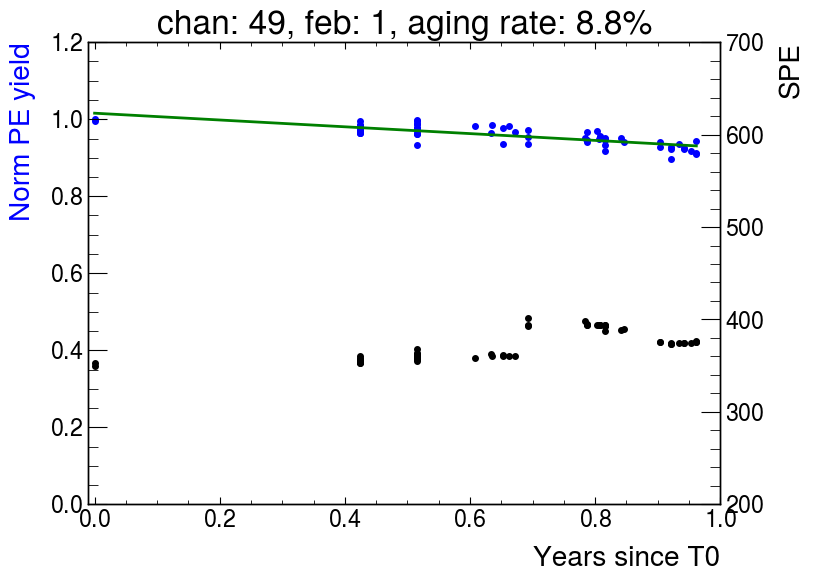

<Figure size 800x600 with 0 Axes>

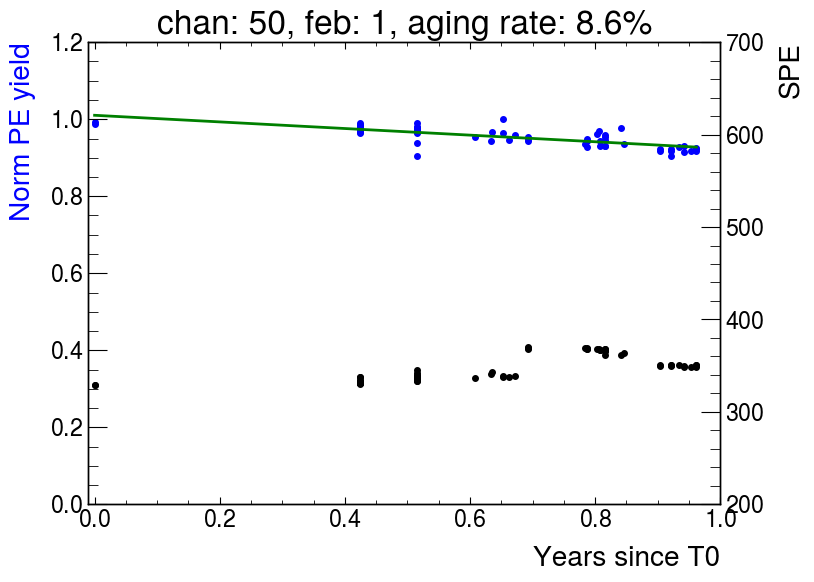

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

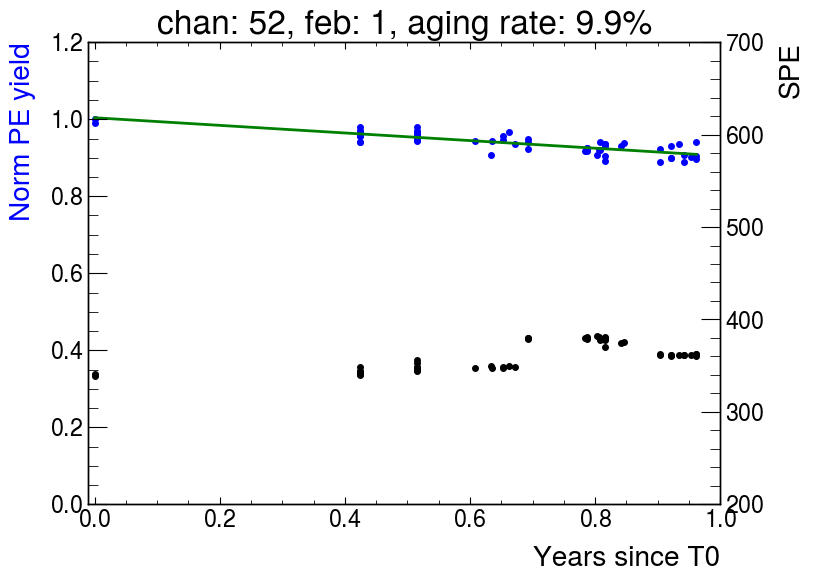

In [26]:
aging_pct=[]
channel_range=list(range(0, 20))+list(range(33, 53))
#channel_range=list(range(0, 2))

for feb in range(0, 2):
  for chan in channel_range:
    plt.figure()
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    #Plot normalized PE over years
    x=df.query('chan==%d and feb==%d'%(chan,feb))['years'].to_numpy()
    y=df.query('chan==%d and feb==%d'%(chan,feb))['PEcorr'].to_numpy()
    y=y/y.max()
    ax1.plot(x, y , 'b.', label="Normalized light yield")
    ax1.set_ylim(0,1.2)
    ax1.set_xlim(-0.01)
    ax1.set_xlabel("Years since T0")
    ax1.set_ylabel('Norm PE yield', color='b')

    #Fit the aging curve
    z4, res, _, _, _ = np.polyfit(x, y, 1, full=True)
    p4 = np.poly1d(z4)
    xx = np.linspace(x.min(), x.max(), 100)
    ax1.plot(xx, p4(xx), '-g')
    aging_pct.append(-p4[1]*100)
    ax1.set_title('chan: %d, feb: %d, aging rate: %.1f%%'%(chan,feb,-p4[1]*100))

    #Plot normalized SPE over years
    x=df.query('chan==%d and feb==%d'%(chan,feb))['years'].to_numpy()
    y=df.query('chan==%d and feb==%d'%(chan,feb))['speT'].to_numpy()
    ax2.plot(x, y , 'k.')
    ax2.set_ylim(200,700)
    ax2.set_ylabel('SPE', color='k');

In [23]:
plt.hist(aging_pct, bins=20, range=(0,20), histtype='step', label='<Aging rate>: %.0f%% $\pm$ %.0f%% (stat)'%(np.mean(aging_pct), np.std(aging_pct)) );
plt.xlabel('Aging rate [%/year]');
plt.legend();